In [1]:
#Load the usual suspects

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
# Load the data

with np.load('/Users/David/Desktop/EPFL Applied ML/cifar4-train.npz', allow_pickle=False) as npz_file:
    pixels = npz_file['pixels'].astype('float32')
    overfeat = npz_file['overfeat']
    labels = npz_file['labels']
    names = npz_file['names']
    allow = npz_file['allow_pickle']
    
print('Pixels : {:}'.format(pixels.shape),
      'Overfeat: {:}'.format(overfeat.shape),
      'Labels: {:}'.format(labels.shape),
      'Names: {:}'.format(names.shape), 
      'Allow pickle: {:}'.format(allow.shape))

Pixels : (5000, 3072) Overfeat: (5000, 4096) Labels: (5000,) Names: (4,) Allow pickle: ()


In [3]:
# Print the class distribution, i.e., the proportion of images in each category.
print('Proportion of images in each category:')
print(100*pd.DataFrame(pd.value_counts(labels, normalize=True)).reset_index().replace({'index': dict(zip(pd.unique(labels), names))}).set_index('index').rename_axis(None).rename(columns={0: 'Class distribution (%)'})) # a bit of reordering so that the print statement throws something intuitive which includes the class names
# 25% for each class, so totally balanced input data.

Proportion of images in each category:
          Class distribution (%)
ship                        25.0
airplane                    25.0
car                         25.0
truck                       25.0


In [4]:
# What is the accuracy of the "most-frequent" baseline? 
dummy = DummyClassifier(strategy='most_frequent').fit(pixels, labels) # fit a dummy classifier for the more frequent
print('Most frequent baseline (%):')
print(dummy.score(pixels, labels)*100) # calculate the dummy score
# 25% - as expected because of the class balance.

Most frequent baseline (%):
25.0


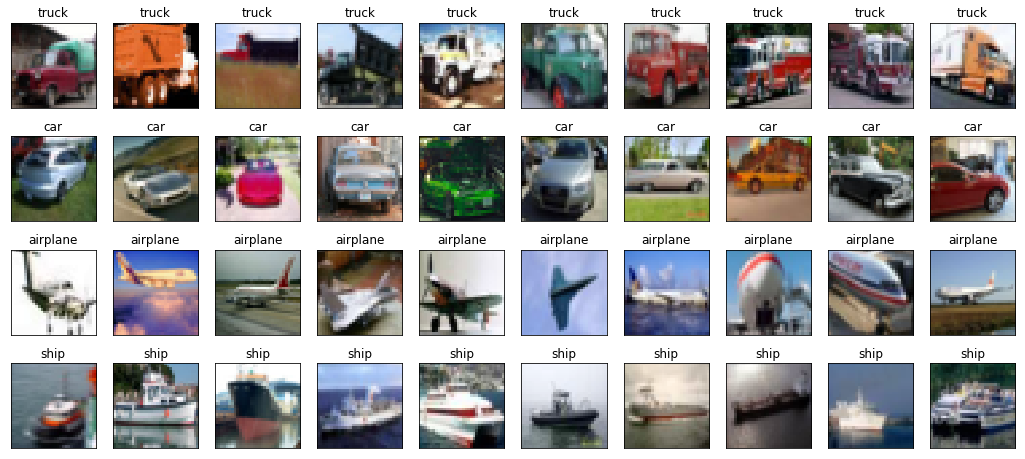

In [5]:
# Plot a few images from the data set, e.g., ten images from each category.

cat_mapping = dict(zip(pd.unique(labels), names)) # dictionary of label-category names mapping
rnd_img = [] # empty list to select random images

for i in np.arange(4): # iterate through the 4 categories
    for j in np.arange(10): # iterate through to select 10 images
        idx = (labels == i) # subset corresponding to category i
        rnd_pick = list(pixels[idx][np.random.choice(np.arange(0, len(pixels[idx])))]) # random picture choice
        rnd_img.append(rnd_pick) # appending of randomly picked pictures at each iteration

rnd_img = np.reshape(rnd_img, (40, pixels.shape[1])) # 40 pictures nicely converted to array with corresponding shape
lab_img = np.array(10*[0]+10*[1]+10*[2]+10*[3]) # picture labels
names_img = np.array([cat_mapping[i] for i in lab_img]) # picture name categories by mapping names to labels

# Create figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(18, 8))

# Plot the 40 randomly selected images
for i, axis in enumerate(axes.flatten()):
    # Get i-th image
    image = rnd_img[i, :]

    # Rescale pixel values between 0 and 1 for plotting, and reshape back to 32x32 pixels and RGB colours
    template = MinMaxScaler(feature_range=(0, 1)).fit_transform(image.reshape(-1, 1)).reshape(32, 32, 3)

    # Plot array with imshow()
    axis.imshow(template)
    axis.set_title(names_img[i])
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()

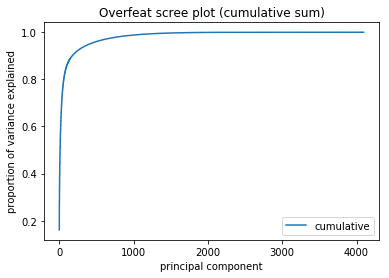

In [112]:
# Create a scree plot of the OverFeat features.
# To avoid the PCA algorithm favoring variables with a large variance, data will be scaled beforehand. To include both scaling and PCA steps, a Pipeline object will be used.

pca_pipe = Pipeline([
    ('scaler', StandardScaler()), # scaling step
    ('pca', PCA(n_components=None)) # pca step with components set to None to include them all
])

# Apply PCA to rescaled overfeat data - y=None because of unsupervised learning
pca_overfeat = pca_pipe.fit(overfeat, y=None)

# Get proportion of variance explained and calculate the cumulative sum
pve = pca_overfeat.steps[1][1].explained_variance_ratio_ # need to access the pca step in the pipeline to get the pve
pve_cumsum = np.cumsum(pve) # cumulative sum of the proportion of variance explained

# Scree plot of the PCA decomposition
plt.step(
    np.arange(1, len(pve) + 1), # Plotting steps
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.title('Overfeat scree plot (cumulative sum)')
plt.legend()
plt.show()

In [113]:
# What is the cumulated proportion of variance explained (PVE) in the first two components?
pve_2c = pve_cumsum[1] # as we are using the cumulative sum, the second element of the array is already the cumulated pve
print('Cumulated PVE (%), first two components: {:.1f}'.format(100*pve_2c))

Cumulated PVE (%), first two components: 23.5


In [114]:
# How many components should we keep to retain 80%, 90%, 95% and 99% of the variance explained?
print('# components to retain 80% of variance explained: {:.0f}'.format(len(pve_cumsum[pve_cumsum < 0.8])+1)) # as we are using the cumulative sum, the number of components to get a pve of at least 80% will be the length of the array for which the cumsum is strictly less than 0.8, with the addition of 1 component to get exactly 0.8 or slightly over.
print('# components to retain 90% of variance explained: {:.0f}'.format(len(pve_cumsum[pve_cumsum < 0.9])+1)) # same as before but with different percentage
print('# components to retain 95% of variance explained: {:.0f}'.format(len(pve_cumsum[pve_cumsum < 0.95])+1))
print('# components to retain 99% of variance explained: {:.0f}'.format(len(pve_cumsum[pve_cumsum < 0.99])+1))

# components to retain 80% of variance explained: 62
# components to retain 90% of variance explained: 176
# components to retain 95% of variance explained: 408
# components to retain 99% of variance explained: 1072


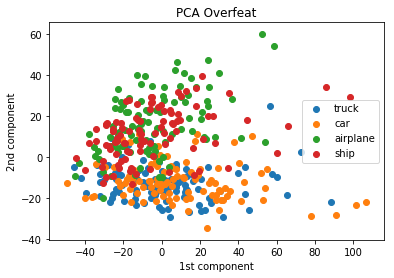

In [115]:
#Finally, apply PCA to create 2d plots of the input data.
#Create a 2d plot of the OverFeat features.

first_component = pca_overfeat.transform(overfeat)[:,0] # select first component of the PCA
second_component = pca_overfeat.transform(overfeat)[:,1] # select second component of the PCA
img_lab = np.array([cat_mapping[i] for i in pd.unique(labels)]) # create a list with the mapped category names

# Plot each image category
for img_cat in pd.unique(labels):
    # Select labels corresponding to one of the iterating categories, and select 100 random pictures for plotting
    idx = (labels == img_cat)
    rnd_select = np.random.choice(np.arange(0, len(overfeat[idx])), 100, replace=False) # select 100 numbers ranging from 0 to the category subset size, without replacement to ensure we pick 100 different ones
    
    # Plot the components
    plt.scatter(
        first_component[idx][rnd_select], second_component[idx][rnd_select],
        label='{}'.format(img_lab[img_cat]) # labels are mapped back to get the categories names
    )

# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('PCA Overfeat')
plt.show()

# The main trend that can be seen is that trucks and cars (bottom) are separated from ships and planes (top). It seems clear that the Overfeat features are already extracted high level features from a prior training.

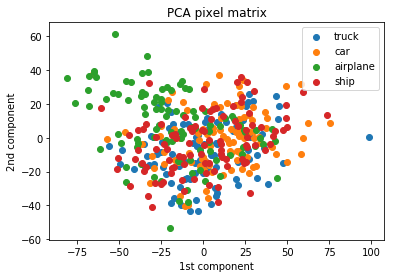

In [116]:
#Create a 2d plot using the matrix of image pixels. Same procedure as before.

# Apply PCA to rescaled overfeat data - y=None because of unsupervised learning
pca_pixels = pca_pipe.fit(pixels, y=None)

first_component_pix = pca_pixels.transform(pixels)[:,0] # select first component of the PCA
second_component_pix = pca_pixels.transform(pixels)[:,1] # select second component of the PCA

# Plot each image category
for img_cat in pd.unique(labels):
    # Select labels corresponding to one of the iterating categories, and select 100 random pictures for plotting
    idx = (labels == img_cat)
    rnd_select = np.random.choice(np.arange(0, len(pixels[idx])), 100, replace=False) # select 100 numbers ranging from 0 to the category subset size, without replacement to ensure we pick 100 different ones
    
    # Plot the components
    plt.scatter(
        first_component_pix[idx][rnd_select], second_component_pix[idx][rnd_select],
        label='{}'.format(img_lab[img_cat]) # labels are mapped back to get the categories names
    )

# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('PCA pixel matrix')
plt.show()

# Compared the overfeat features, it seems that there is no correlation whatsoever between the different categories when looking at the pixel matrix